In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

## 🏠 Data Loading and Initial Inspection

In [2]:
train_df = pd.read_csv("/home/hardik/Desktop/python_intern/house-prices-advanced-regression-techniques/train.csv")
test_df=pd.read_csv("/home/hardik/Desktop/python_intern/house-prices-advanced-regression-techniques/test.csv")

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

print("\n--- Descriptive Statistics for Numerical Columns ---")
print(train_df.describe().T)

print("\n--- Descriptive Statistics for Categorical Columns ---")
print(train_df.describe(include=['object']).T)

Training data shape: (1460, 81)
Test data shape: (1459, 80)

--- Descriptive Statistics for Numerical Columns ---
                count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00  

## 💰 Target Variable Transformation (`SalePrice`)

--- SalePrice Statistics ---
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


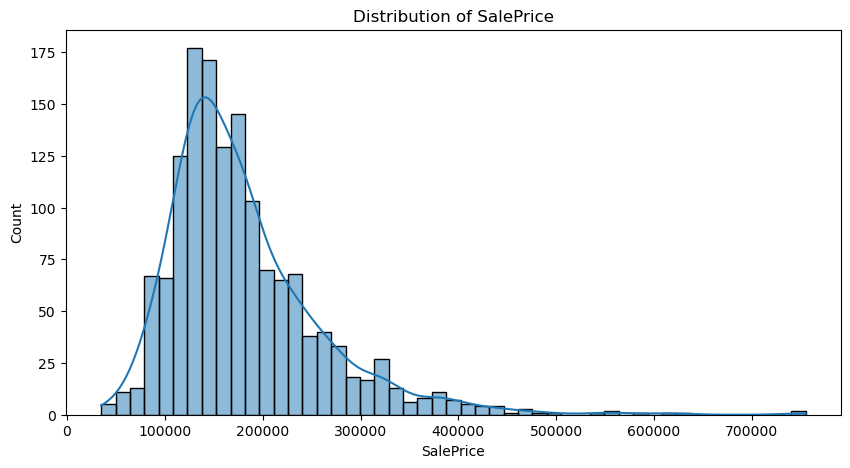

In [4]:
print("--- SalePrice Statistics ---")
print(train_df['SalePrice'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

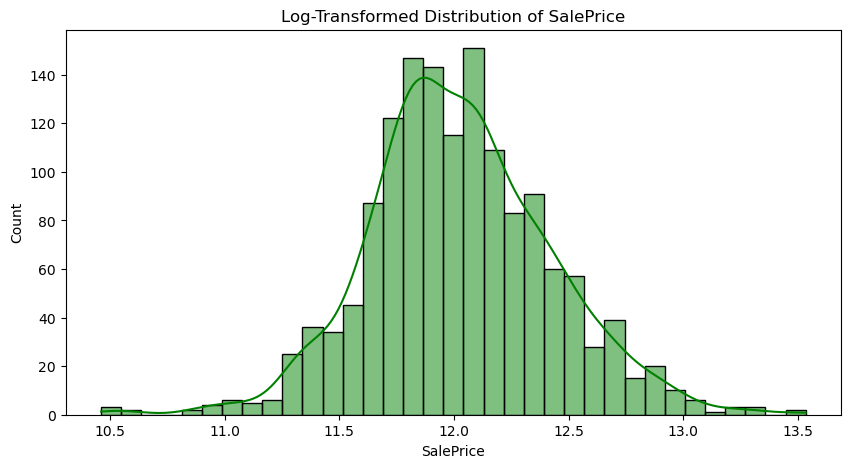

In [5]:
# Log-transform the target variable to reduce skewness
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(10, 5))
sns.histplot(train_df['SalePrice'], kde=True, color='green')
plt.title('Log-Transformed Distribution of SalePrice')
plt.show()

# Store IDs and SalePrice, then drop them from the main dataframes
train_id = train_df['Id']
test_id = test_df['Id']
y_train = train_df['SalePrice']

train_df.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

## 🛠️ Data Merging and Missing Value Imputation

In [6]:
# Combine train and test data for easier preprocessing
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
print(f"Combined data shape: {all_data.shape}")

print("\nMissing values in LotFrontage before imputation:", all_data['LotFrontage'].isnull().sum())

Combined data shape: (2919, 79)

Missing values in LotFrontage before imputation: 486


In [7]:
# Impute 'None' for categorical features where NA means absence
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

# Impute 0 for numerical features where NA means absence
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

# Impute LotFrontage with the median of the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Impute with the most frequent value (mode) for the rest (single missing values)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Drop Utilities as it has very little variance (almost all 'AllPub')
all_data = all_data.drop(['Utilities'], axis=1)

print("Missing values handled!")
print("\nRemaining missing values (should be 0 or near 0):")
print(all_data.isnull().sum().max())

Missing values handled!

Remaining missing values (should be 0 or near 0):
0


## ⚙️ Feature Engineering and Transformation

In [8]:
# 1. Convert Numerical features that are actually categories to strings
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# 2. Label Encode ordered categorical features
cols_to_encode = (
    'FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
    'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'LandSlope',
    'LotShape', 'PavedDrive', 'Street', 'Alley', 'OverallCond'
)
for c in cols_to_encode:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# 3. Add a feature for total square footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

print("Feature transformation and engineering complete.")

Feature transformation and engineering complete.


In [9]:
# 4. Apply log-transformation to highly skewed numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

print(f"\n{len(skewed_feats)} skewed numerical features were log-transformed.")


23 skewed numerical features were log-transformed.


In [10]:
# 5. One-hot encode the remaining categorical features
all_data = pd.get_dummies(all_data)
print(f"Data shape after one-hot encoding: {all_data.shape}")

Data shape after one-hot encoding: (2919, 255)


## 📊 Final Split and Data Visualization

In [11]:
# Split the data back into training and testing sets
X_train = all_data[:len(train_df)]
X_test = all_data[len(train_df):]

print("--- Preprocessing Complete ---")
print(f"Shape of final training features (X_train): {X_train.shape}")
print(f"Shape of final test features (X_test): {X_test.shape}")
print(f"Shape of log-transformed target variable (y_train): {y_train.shape}")

--- Preprocessing Complete ---
Shape of final training features (X_train): (1460, 255)
Shape of final test features (X_test): (1459, 255)
Shape of log-transformed target variable (y_train): (1460,)


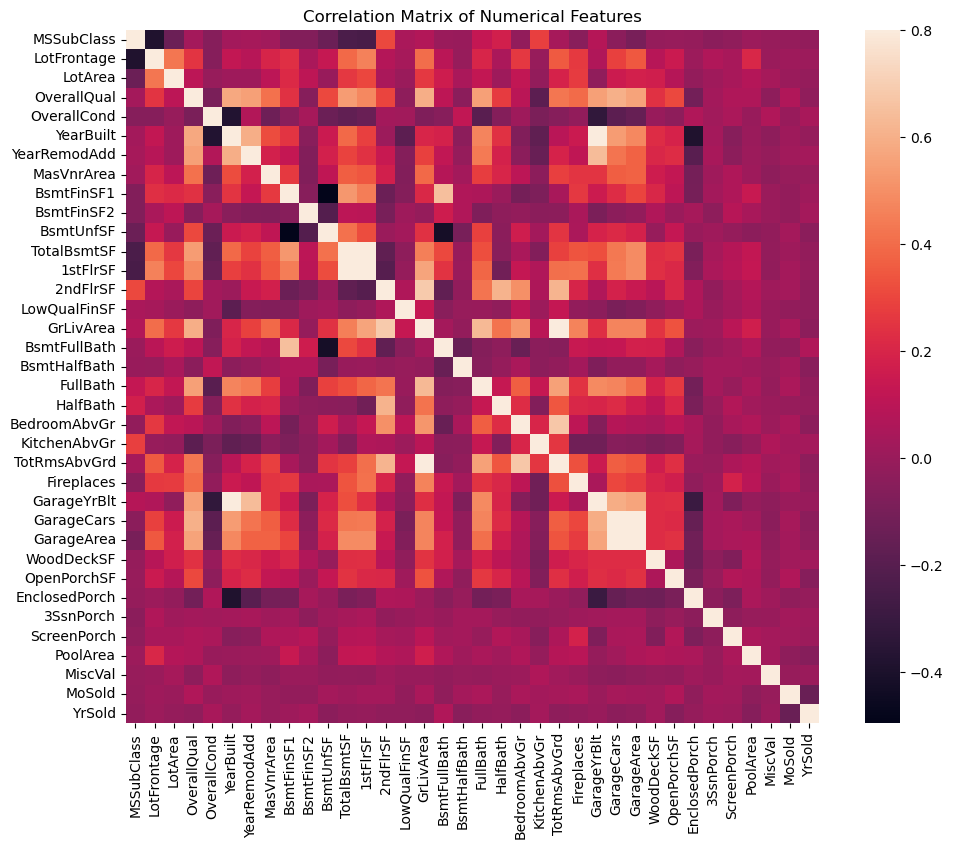

In [12]:
# Correlation Heatmap of original numerical features
# Note: The 'train_df' used here is the one *before* all preprocessing steps (excluding SalePrice drop) which is fine for initial exploration.

# 1. Select only the columns with numerical data types
numerical_df = train_df.select_dtypes(include=np.number)

# 2. Create the correlation matrix from the numerical-only DataFrame
corrmat = numerical_df.corr()

# 3. Plot the heatmap
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

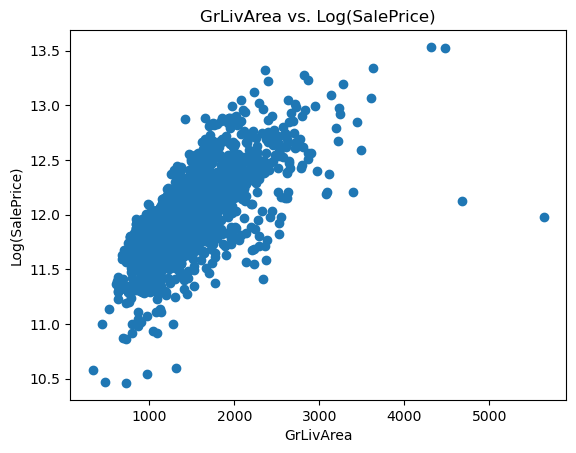

In [13]:
# Scatter plot of a key feature vs. log-transformed target variable
plt.scatter(x=train_df['GrLivArea'], y=y_train)
plt.ylabel('Log(SalePrice)')
plt.xlabel('GrLivArea')
plt.title('GrLivArea vs. Log(SalePrice)')
plt.show()